In [1]:
import subprocess, sys, importlib

def ensure(package, import_name=None):
    name = import_name or package
    try:
        importlib.import_module(name)
        return True
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        importlib.invalidate_caches()
        importlib.import_module(name)
        return True

for pkg, imp in [
    ("nltk", "nltk"),
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("tqdm", "tqdm"),
    ("matplotlib", "matplotlib"),
]:
    ensure(pkg, imp)

print("✓ Dependencias listas")


✓ Dependencias listas


In [2]:
## 2. Descarga de recursos NLTK (robusta y condicional)
# %%
import ssl
import nltk

# Forzar contexto SSL laxo si hace falta
try:
    _create_unverified_https_context = ssl._create_unverified_context  # type: ignore
    ssl._create_default_https_context = _create_unverified_https_context
except Exception:
    pass

to_check = {
    "punkt": "tokenizers/punkt",
    "wordnet": "corpora/wordnet",
    "omw-1.4": "corpora/omw-1.4",
    "averaged_perceptron_tagger": "taggers/averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng": "taggers/averaged_perceptron_tagger_eng",
    "sentiwordnet": "corpora/sentiwordnet",
    "vader_lexicon": "sentiment/vader_lexicon",
}

def ensure_nltk(resource, path_fragment):
    try:
        nltk.data.find(path_fragment)
        return True
    except LookupError:
        try:
            nltk.download(resource, quiet=True)
            nltk.data.find(path_fragment)
            return True
        except Exception as e:
            print(f"⚠ No se pudo descargar/encontrar {resource}: {e}")
            return False

ok = {r: ensure_nltk(r, p) for r, p in to_check.items()}
if not ok.get("averaged_perceptron_tagger") and not ok.get("averaged_perceptron_tagger_eng"):
    nltk.download("averaged_perceptron_tagger", quiet=True)

print("✓ Recursos NLTK verificados/descargados")


⚠ No se pudo descargar/encontrar wordnet: 
**********************************************************************
  Resource wordnet not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('wordnet')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load corpora/wordnet

  Searched in:
    - 'C:\\Users\\wail-/nltk_data'
    - 'c:\\Users\\wail-\\.conda\\envs\\ml\\nltk_data'
    - 'c:\\Users\\wail-\\.conda\\envs\\ml\\share\\nltk_data'
    - 'c:\\Users\\wail-\\.conda\\envs\\ml\\lib\\nltk_data'
    - 'C:\\Users\\wail-\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************

⚠ No se pudo descargar/encontrar omw-1.4: 
**********************************************************************
  Resource omw-1.4 not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.do

In [3]:
## 3. Configuración, léxicos y utilidades
from dataclasses import dataclass, field

PALABRAS_POSITIVAS = {
    'good','great','awesome','excellent','amazing','wonderful','fantastic',
    'love','loved','loving','best','better','perfect','nice','beautiful',
    'happy','glad','joy','joyful','pleased','delighted','enjoy','enjoyed',
    'like','liked','favorite','brilliant','outstanding','superb','impressive',
    'positive','success','successful','win','winner','winning','recommend',
    'fun','interesting','cool','sweet','thanks','thank','appreciate',
    'worthy','worth','quality','helpful','easy','comfortable','pretty',
    'gorgeous','adorable','cute','charm','charming','pleasant','satisfied','awesome'
}

PALABRAS_NEGATIVAS = {
    'bad','terrible','awful','horrible','worst','worse','poor','hate',
    'hated','dislike','disappointing','disappointed','disappointment',
    'sad','angry','upset','annoying','annoyed','frustrating','frustrated',
    'boring','bored','dull','useless','waste','wasted','fail','failed',
    'failure','problem','issue','trouble','difficult','hard','sucks',
    'stupid','dumb','ugly','disgusting','nasty','gross','crap','shit',
    'damn','hell','wrong','error','broken','broke','uncomfortable',
    'painful','pain','suffer','suffering','regret','sorry','weak','scam','buggy'
}

NEGACIONES = {
    'not','no',"n't",'never','neither','nobody','nothing','nowhere',
    'none','nor','cannot','cant',"can't","won't","wouldn't","shouldn't",
    "couldn't","doesn't","don't","didn't","isn't","aren't","wasn't","weren't"
}

INTENSIFICADORES = {
    'very':1.5,'really':1.5,'extremely':2.0,'absolutely':1.8,
    'incredibly':1.8,'highly':1.5,'particularly':1.3,'especially':1.3,
    'totally':1.6,'completely':1.6,'utterly':1.7,'quite':1.2,
    'so':1.4,'too':1.3,'super':1.5,'exceptionally':1.8
}

ATENUADORES = {
    'somewhat':0.5,'slightly':0.5,'barely':0.4,'hardly':0.4,
    'almost':0.6,'nearly':0.6,'kind':0.5,'sort':0.5,
    'little':0.6,'bit':0.6,'rather':0.7,'fairly':0.7
}

# Emoticonos (NO emojis). Contribuyen como pequeño boost de polaridad.
EMOTICON_SENT = {
    ":)": 0.6, ":-)": 0.6, ":D": 0.9, ":-D": 0.9, ";)": 0.4,
    ":(": -0.6, ":-(": -0.6, ":'(": -0.9, ">:(": -1.1, "XD": 0.7
}

PIVOTES_CONTRASTE = {"but","however","though","although"}

@dataclass
class Config:
    usar_sentiwordnet: bool = True
    ventana_negacion: int = 3
    reset_negacion_en_puntuacion: bool = True
    boost_exclamacion: float = 0.10
    boost_repeticion: float = 0.10
    peso_pre_contraste: float = 0.5
    peso_post_contraste: float = 1.5
    max_stack_mod: int = 2
    limites_puntuacion_reset: set = field(default_factory=lambda: {".","!","?",";","—","-","…"})
    pos: set = field(default_factory=lambda: set(PALABRAS_POSITIVAS))
    neg: set = field(default_factory=lambda: set(PALABRAS_NEGATIVAS))
    negaciones: set = field(default_factory=lambda: set(NEGACIONES))
    intensificadores: dict = field(default_factory=lambda: dict(INTENSIFICADORES))
    atenuadores: dict = field(default_factory=lambda: dict(ATENUADORES))

CFG = Config()
print("✓ Config preparada")



✓ Config preparada


In [4]:
## 4. Preprocesado de texto (conserva señales de sentimiento)
import re
import pandas as pd
import numpy as np

URL_RE = re.compile(r'https?://\S+|www\.\S+')
MENTION_RE = re.compile(r'@\w+')
NON_SENT_CHARS_RE = re.compile(r"[^\w\s!?\.\'\-]", flags=re.UNICODE)
MULTISPACE_RE = re.compile(r"\s+")
REPEAT_CHAR_RE = re.compile(r'([a-zA-Z])\1{2,}')

def normalizar_emoticonos(texto: str) -> float:
    total = 0.0
    for emo, val in EMOTICON_SENT.items():
        total += texto.count(emo) * val
    return total

def preprocesar_texto(texto: str) -> str:
    if pd.isna(texto):
        return ""
    t = str(texto)
    t = t.lower()
    t = URL_RE.sub("", t)
    t = MENTION_RE.sub("", t)
    t = NON_SENT_CHARS_RE.sub(" ", t)
    t = MULTISPACE_RE.sub(" ", t).strip()
    return t

print("✓ Funciones de preprocesado listas")


✓ Funciones de preprocesado listas


In [5]:
## 5. SentiWordNet, etiquetado POS y caché
import nltk
from functools import lru_cache
from nltk.corpus import wordnet as wn, sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

LEMMATIZER = WordNetLemmatizer()

def _to_wn_pos(tag: str):
    if tag.startswith('J'):
        return wn.ADJ
    if tag.startswith('V'):
        return wn.VERB
    if tag.startswith('N'):
        return wn.NOUN
    if tag.startswith('R'):
        return wn.ADV
    return wn.NOUN

@lru_cache(maxsize=200000)
def senti_from_swn(lemma: str, wn_pos) -> float:
    try:
        synsets = list(swn.senti_synsets(lemma, pos=wn_pos))
        if not synsets:
            return 0.0
        best = max(synsets, key=lambda ss: abs(ss.pos_score() - ss.neg_score()))
        return best.pos_score() - best.neg_score()
    except Exception:
        return 0.0

def pos_tag_tokens(tokens):
    try:
        return nltk.pos_tag(tokens)
    except LookupError:
        nltk.download("averaged_perceptron_tagger", quiet=True)
        return nltk.pos_tag(tokens)


In [6]:
## 6. Señales adicionales y análisis de características
def contar_exclamaciones(texto: str) -> int:
    return texto.count('!')

def contar_repeticiones_letras(texto: str) -> int:
    return len(REPEAT_CHAR_RE.findall(texto))

print("✓ Señales listas")

✓ Señales listas


In [7]:
## 7. Motor de análisis basado en reglas (mejorado)
PIVOTES_CONTRASTE = {"but","however","though","although"}

def _aplicar_modificador(score_word: float, modificador: float, negacion_activa: bool) -> float:
    v = score_word * modificador
    return -v if negacion_activa else v

def _segmentos_contraste(tokens):
    for i, tok in enumerate(tokens):
        if tok in PIVOTES_CONTRASTE:
            return tokens[:i], tokens[i+1:]
    return tokens, []

def analizar_sentimiento_texto(texto: str, cfg: Config = CFG) -> float:
    if not texto:
        return 0.0

    # Boost por emoticonos en el texto ORIGINAL (no preprocesado)
    boost_emoticon = normalizar_emoticonos(texto)

    t = preprocesar_texto(texto)
    if not t:
        return boost_emoticon

    tokens = word_tokenize(t)
    if not tokens:
        return boost_emoticon

    left, right = _segmentos_contraste(tokens)

    def puntuar_bloque(btokens):
        score = 0.0
        if not btokens:
            return score
        tagged = pos_tag_tokens(btokens)
        negacion_activa = False
        ventana = 0
        stack_mod = 0
        modificador = 1.0

        for i, (tok, pos) in enumerate(tagged):
            if cfg.reset_negacion_en_puntuacion and tok in cfg.limites_puntuacion_reset:
                negacion_activa = False
                ventana = 0
                modificador = 1.0
                stack_mod = 0
                continue

            if negacion_activa:
                ventana += 1
                if ventana > cfg.ventana_negacion:
                    negacion_activa = False
                    ventana = 0

            if tok in cfg.negaciones:
                negacion_activa = True
                ventana = 0
                continue

            if tok in cfg.intensificadores:
                modificador *= cfg.intensificadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = max(modificador, cfg.intensificadores[tok])
                continue

            if tok in cfg.atenuadores:
                modificador *= cfg.atenuadores[tok]
                stack_mod += 1
                if stack_mod > cfg.max_stack_mod:
                    modificador = min(modificador, cfg.atenuadores[tok])
                continue

            s = 0.0
            if tok in cfg.pos:
                s = 1.0
            elif tok in cfg.neg:
                s = -1.0
            elif cfg.usar_sentiwordnet:
                wn_pos = _to_wn_pos(pos)
                lemma = LEMMATIZER.lemmatize(tok, pos=wn_pos)
                s = senti_from_swn(lemma, wn_pos)

            if s != 0.0:
                score += _aplicar_modificador(s, modificador, negacion_activa)
                modificador = 1.0
                stack_mod = 0

        return score

    score_left = puntuar_bloque(left)
    score_right = puntuar_bloque(right)

    if right:
        score = CFG.peso_pre_contraste * score_left + CFG.peso_post_contraste * score_right
    else:
        score = score_left

    excls = contar_exclamaciones(texto)
    reps = contar_repeticiones_letras(texto)
    if excls > 0:
        score *= (1 + CFG.boost_exclamacion * excls)
    if reps > 0:
        score *= (1 + CFG.boost_repeticion * reps)

    score += boost_emoticon
    return score

# Pruebas rápidas
ejemplos = [
    "This is amazing! I love it! :)",
    "This is terrible. I hate it :(",
    "Not bad, quite good actually.",
    "This is not good at all.",
    "BEST MOVIE EVER!!!",
    "I wanted to like it, but it was boring...",
    "Great camera, however the battery is awful :(",
    "soooo goooood!!!",
    "I can't say it's bad",
]
for e in ejemplos:
    print(e, "->", round(analizar_sentimiento_texto(e), 3))


This is amazing! I love it! :) -> 3.15
This is terrible. I hate it :( -> -2.725
Not bad, quite good actually. -> 0.175
This is not good at all. -> -0.875
BEST MOVIE EVER!!! -> 1.3
I wanted to like it, but it was boring... -> -1.125
Great camera, however the battery is awful :( -> -1.788
soooo goooood!!! -> 0.0
I can't say it's bad -> -1.125


In [8]:
## 8. VADER como referencia (silver labels) y utilidades
from nltk.sentiment import SentimentIntensityAnalyzer

VADER = SentimentIntensityAnalyzer()

def vader_label(texto: str, pos_th=0.05, neg_th=-0.05):
    """Devuelve 4 (pos), 0 (neg) o None (neutral) según compound de VADER."""
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return None
    s = VADER.polarity_scores(str(texto))
    c = s["compound"]
    if c > pos_th: return 4
    if c < neg_th: return 0
    return None  # neutro

def vader_compound(texto: str):
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return 0.0
    return VADER.polarity_scores(str(texto))["compound"]

print("✓ VADER listo")


✓ VADER listo


In [9]:

from nltk.sentiment import SentimentIntensityAnalyzer

VADER = SentimentIntensityAnalyzer()

def vader_label(texto: str, pos_th=0.05, neg_th=-0.05):
    """Devuelve 4 (pos), 0 (neg) o None (neutral) según compound de VADER."""
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return None
    s = VADER.polarity_scores(str(texto))
    c = s["compound"]
    if c > pos_th: return 4
    if c < neg_th: return 0
    return None  # neutro

def vader_compound(texto: str):
    if texto is None or (isinstance(texto, float) and np.isnan(texto)):
        return 0.0
    return VADER.polarity_scores(str(texto))["compound"]

print("✓ VADER listo")


✓ VADER listo


In [10]:
## 9. Carga del dataset
import pandas as pd

DATA_PATH = "dataset/df_200k.csv"

df = pd.read_csv(DATA_PATH)
print(f"Dataset cargado: {len(df):,} registros")

# Detectar columna de texto
text_col_candidates = [c for c in df.columns if c.lower() in {"text","tweet","review","content"}]
if not text_col_candidates:
    str_props = {c: (df[c].astype(str).str.len() > 0).mean() for c in df.columns}
    text_col = max(str_props, key=str_props.get)
else:
    text_col = text_col_candidates[0]

print(f"Columna de texto detectada: '{text_col}'")
print("⚠ Ignorando 'target' si existe; usamos VADER para evaluación.")


Dataset cargado: 200,000 registros
Columna de texto detectada: 'text'
⚠ Ignorando 'target' si existe; usamos VADER para evaluación.


In [11]:
## 10. Preprocesamiento en la tabla
from tqdm.auto import tqdm
tqdm.pandas(desc="Preprocesando")

df["text_clean"] = df[text_col].progress_apply(preprocesar_texto)
print("✓ Preprocesamiento completado")
print(df[[text_col,"text_clean"]].head())


Preprocesando:   0%|          | 0/200000 [00:00<?, ?it/s]

✓ Preprocesamiento completado
                                                text  \
0  Looks like the sun finally located Trondheim ;...   
1  A long weekend begins. The sun is shining and ...   
2         to the beach we go! hope it stays nice...    
3  @JBFutureboy I missed it  busted need to do a ...   
4          Why I can't change my background image??    

                                          text_clean  
0  looks like the sun finally located trondheim -...  
1  a long weekend begins. the sun is shining and ...  
2          to the beach we go! hope it stays nice...  
3  i missed it busted need to do a reunion tour. ...  
4           why i can't change my background image??  


In [12]:
## 11. Calibración de umbral contra VADER (muestra, descartando neutros)
import numpy as np
from tqdm.auto import tqdm

tam_muestra = min(20000, len(df))
sample = df.sample(n=tam_muestra, random_state=42).copy()

# Etiquetas VADER sobre TEXTO ORIGINAL (mejor para VADER)
tqdm.pandas(desc="VADER (muestra)")
sample["vader_label"] = sample[text_col].progress_apply(vader_label)

# Filtrar a pos/neg (descartar neutros)
mask_eval = sample["vader_label"].isin([0,4])
valid = sample[mask_eval].copy()

if len(valid) < 100:
    mejor_umbral = 0.0
    print("⚠ Muy pocos casos pos/neg en la muestra (según VADER). Umbral por defecto = 0.0")
else:
    tqdm.pandas(desc="Scoring muestra (reglas)")
    valid["score"] = valid["text_clean"].progress_apply(analizar_sentimiento_texto)

    # Búsqueda más fina de umbral
    umbrales = np.linspace(-2.0, 2.0, 81)
    def metricas_basicas(y_true, y_pred):
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        acc = (y_true == y_pred).mean() if len(y_true) else 0.0
        neg_true = (y_true==0).sum()
        pos_true = (y_true==4).sum()
        neg_correct = ((y_true==0) & (y_pred==0)).sum()
        pos_correct = ((y_true==4) & (y_pred==4)).sum()
        recall_neg = (neg_correct/neg_true) if neg_true else 0.0
        recall_pos = (pos_correct/pos_true) if pos_true else 0.0
        bacc = 0.5*(recall_neg+recall_pos)
        return {"accuracy":float(acc),"balanced_accuracy":float(bacc),
                "recall_neg":float(recall_neg),"recall_pos":float(recall_pos)}

    mejor_umbral, metr_mejor = None, None
    y_true = valid["vader_label"].values
    scores = valid["score"].values
    for u in umbrales:
        y_pred = np.where(scores > u, 4, 0)
        m = metricas_basicas(y_true, y_pred)
        if (metr_mejor is None) or (m["balanced_accuracy"] > metr_mejor["balanced_accuracy"]):
            mejor_umbral, metr_mejor = u, m

    print("✓ Calibración vs VADER completada")
    print(f"Mejor umbral: {mejor_umbral:.3f}")
    print("Métricas (muestra vs VADER):", metr_mejor)


VADER (muestra):   0%|          | 0/20000 [00:00<?, ?it/s]

Scoring muestra (reglas):   0%|          | 0/14529 [00:00<?, ?it/s]

✓ Calibración vs VADER completada
Mejor umbral: 0.150
Métricas (muestra vs VADER): {'accuracy': 0.7331543808933857, 'balanced_accuracy': 0.7430871486788815, 'recall_neg': 0.7789413556740289, 'recall_pos': 0.707232941683734}


In [13]:
## 12. Scoring/predicción en todo el dataset + VADER para evaluación
from tqdm.auto import tqdm
tqdm.pandas(desc="Scoring dataset (reglas)")

df["sentiment_score"] = df["text_clean"].progress_apply(analizar_sentimiento_texto)
df["sentiment_pred"] = (df["sentiment_score"] > mejor_umbral).astype(int).replace({0:0,1:4})

# VADER sobre todo el dataset (texto original)
tqdm.pandas(desc="VADER (completo)")
df["vader_label"] = df[text_col].progress_apply(vader_label)
df["vader_compound"] = df[text_col].progress_apply(vader_compound)

print("Distribución de predicciones (reglas):")
print(df["sentiment_pred"].value_counts())
print(df["sentiment_pred"].value_counts(normalize=True))
print("\nDistribución VADER (silver):")
print(df["vader_label"].value_counts(dropna=False))


Scoring dataset (reglas):   0%|          | 0/200000 [00:00<?, ?it/s]

VADER (completo):   0%|          | 0/200000 [00:00<?, ?it/s]

VADER (completo):   0%|          | 0/200000 [00:00<?, ?it/s]

Distribución de predicciones (reglas):
sentiment_pred
0    102013
4     97987
Name: count, dtype: int64
sentiment_pred
0    0.510065
4    0.489935
Name: proportion, dtype: float64

Distribución VADER (silver):
vader_label
4.0    92656
NaN    55445
0.0    51899
Name: count, dtype: int64


Conteos (absolutos):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),40674,11225
Real POS (VADER=4),27365,65291



Porcentajes por FILA (≈ recall por clase VADER):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),78.37,21.63
Real POS (VADER=4),29.53,70.47



Porcentajes por COLUMNA (≈ precision de nuestro modelo):


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),59.78,14.67
Real POS (VADER=4),40.22,85.33



Porcentajes sobre el TOTAL:


,Pred NEG (Reglas=0),Pred POS (Reglas=4)
Real NEG (VADER=0),28.14,7.77
Real POS (VADER=4),18.93,45.17


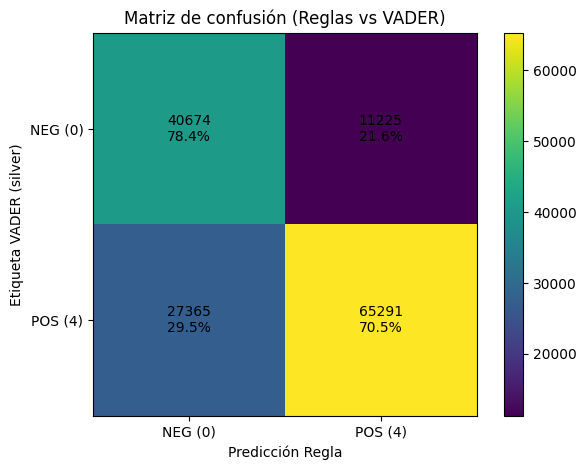

In [14]:
## 13. Matriz de confusión (Nuestro modelo vs VADER) — neutros descartados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

mask = df["vader_label"].isin([0,4]) & df["sentiment_pred"].isin([0,4])
if mask.sum() == 0:
    print("⚠ No hay datos suficientes (VADER pos/neg) para matriz de confusión.")
else:
    y_true = (df.loc[mask, "vader_label"] == 4).astype(int).values  # 0/1
    y_pred = (df.loc[mask, "sentiment_pred"] == 4).astype(int).values

    TN = int(((y_true==0) & (y_pred==0)).sum())
    FP = int(((y_true==0) & (y_pred==1)).sum())
    FN = int(((y_true==1) & (y_pred==0)).sum())
    TP = int(((y_true==1) & (y_pred==1)).sum())
    cm = np.array([[TN, FP],[FN, TP]], dtype=int)

    df_counts = pd.DataFrame(
        cm, index=["Real NEG (VADER=0)","Real POS (VADER=4)"],
        columns=["Pred NEG (Reglas=0)","Pred POS (Reglas=4)"]
    )
    row_sums = df_counts.sum(axis=1).replace(0, np.nan)
    col_sums = df_counts.sum(axis=0).replace(0, np.nan)
    total = df_counts.values.sum()

    df_row_pct = (df_counts.div(row_sums, axis=0) * 100).round(2)
    df_col_pct = (df_counts.div(col_sums, axis=1) * 100).round(2)
    df_all_pct = (df_counts / total * 100).round(2) if total>0 else df_counts.astype(float)

    print("Conteos (absolutos):")
    display(df_counts)
    print("\nPorcentajes por FILA (≈ recall por clase VADER):")
    display(df_row_pct)
    print("\nPorcentajes por COLUMNA (≈ precision de nuestro modelo):")
    display(df_col_pct)
    print("\nPorcentajes sobre el TOTAL:")
    display(df_all_pct)

    # Heatmap simple con anotaciones (conteo + % por fila)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title("Matriz de confusión (Reglas vs VADER)")
    plt.xlabel("Predicción Regla")
    plt.ylabel("Etiqueta VADER (silver)")
    plt.xticks([0,1], ["NEG (0)","POS (4)"])
    plt.yticks([0,1], ["NEG (0)","POS (4)"])

    for i in range(2):
        for j in range(2):
            val = cm[i, j]
            fila = cm[i, :].sum()
            pct_row = (val / fila * 100) if fila > 0 else 0.0
            plt.text(j, i, f"{val}\n{pct_row:.1f}%", ha="center", va="center")

    plt.colorbar()
    plt.tight_layout()
    plt.show()


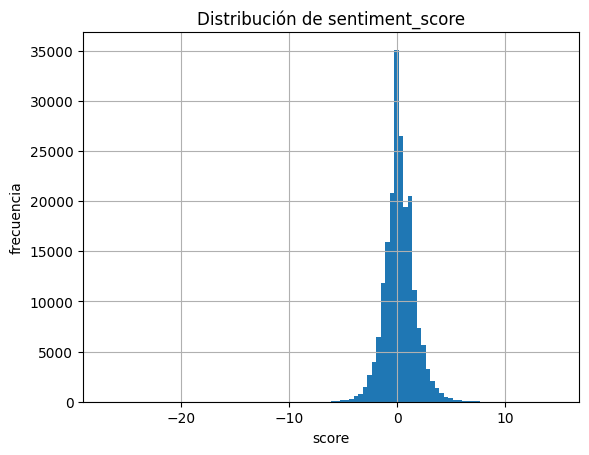

In [15]:
## 14. Gráfico de distribución de scores
import matplotlib.pyplot as plt

plt.figure()
df["sentiment_score"].hist(bins=100)
plt.title("Distribución de sentiment_score")
plt.xlabel("score")
plt.ylabel("frecuencia")
plt.show()


In [16]:
## 15. Ejemplos donde el modelo se equivoca contra VADER (5 FP y 5 FN)
# - **FP**: VADER=0 (neg) y nuestro modelo=4 (pos)
# - **FN**: VADER=4 (pos) y nuestro modelo=0 (neg)
# Se priorizan los casos con mayor distancia al umbral.
import numpy as np
import pandas as pd
from IPython.display import display

if "sentiment_pred" not in df.columns or "sentiment_score" not in df.columns or "vader_label" not in df.columns:
    print("⚠ Faltan columnas. Ejecuta scoring y VADER antes.")
else:
    mask_fp = (df["vader_label"] == 0) & (df["sentiment_pred"] == 4)
    mask_fn = (df["vader_label"] == 4) & (df["sentiment_pred"] == 0)

    cols = [text_col, "sentiment_score", "sentiment_pred", "vader_label", "vader_compound"]
    ejemplos_fp = df.loc[mask_fp, cols].copy()
    ejemplos_fn = df.loc[mask_fn, cols].copy()

    umbral = float(globals().get("mejor_umbral", 0.0))
    ejemplos_fp["dist_umbral"] = (ejemplos_fp["sentiment_score"] - umbral).abs()
    ejemplos_fn["dist_umbral"] = (ejemplos_fn["sentiment_score"] - umbral).abs()

    top_fp = ejemplos_fp.sort_values("dist_umbral", ascending=False).head(5)
    top_fn = ejemplos_fn.sort_values("dist_umbral", ascending=False).head(5)

    print("──────────── FALSOS POSITIVOS (VADER NEG=0, Reglas POS=4) ────────────")
    for _, row in top_fp.iterrows():
        txt = str(row[text_col]).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | VADER: NEG | Pred(Reglas): POS ✗  | compound={row['vader_compound']:.3f}\n")

    print("──────────── FALSOS NEGATIVOS (VADER POS=4, Reglas NEG=0) ────────────")
    for _, row in top_fn.iterrows():
        txt = str(row[text_col]).replace("\n", " ")
        print(f"Texto: {txt[:200]}...")
        print(f"Score: {row['sentiment_score']:.3f} | VADER: POS | Pred(Reglas): NEG ✗  | compound={row['vader_compound']:.3f}\n")

    print("Tabla — 5 FALSOS POSITIVOS")
    display(top_fp.drop(columns=['dist_umbral']).reset_index(drop=True))

    print("Tabla — 5 FALSOS NEGATIVOS")
    display(top_fn.drop(columns=['dist_umbral']).reset_index(drop=True))


──────────── FALSOS POSITIVOS (VADER NEG=0, Reglas POS=4) ────────────
Texto: WTF DISNEY?! Thought u made happy films!! I just sobbed my way through 90% of that movie  SOOO sad, but so amazing!!!! Go watch UP!...
Score: 7.128 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.679

Texto: @ddlovato DEMI I CAN'T,BUT I'D LOVE TO   I'M FROM PERU!! COME BACK PLEASE.YOUR VOICE IS AMAZING, WE LOVE YOU....
Score: 6.975 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.596

Texto: Morning!!!...yey I'm no longer a lobster..but is wondering will going in the sun make it return..probably...ahh well.. ...
Score: 6.419 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.472

Texto: KZ2 patch delayed. Too bad. However It looks like there is going to be some realy nice weather this weekend in London so its not all bad ...
Score: 6.013 | VADER: NEG | Pred(Reglas): POS ✗  | compound=-0.557

Texto: goin to get ready for work  super lame!!!!! but i get off kinda early so idk just gotta make it through these 

,text,sentiment_score,sentiment_pred,vader_label,vader_compound
0,WTF DISNEY?! Thought u made happy films!! I ju...,7.12800,4,0.0,-0.6792
1,"@ddlovato DEMI I CAN'T,BUT I'D LOVE TO I'M F...",6.97500,4,0.0,-0.5956
2,Morning!!!...yey I'm no longer a lobster..but ...,6.41875,4,0.0,-0.4724
3,KZ2 patch delayed. Too bad. However It looks l...,6.01250,4,0.0,-0.5574
4,goin to get ready for work super lame!!!!! bu...,5.85000,4,0.0,-0.4354


Tabla — 5 FALSOS NEGATIVOS


,text,sentiment_score,sentiment_pred,vader_label,vader_compound
0,"Don't be emotional Leah, you hate the douche n...",-9.52000,0,4.0,0.3749
1,@nkotbgal21 you just keep rubbing that in!! ...,-7.99250,0,4.0,0.3544
2,"@n0modestbear Do it!! Although, when they get ...",-7.40625,0,4.0,0.3355
3,im too BIG!!!!!!!!!!!!!!!!!! need to get thinn...,-7.31500,0,4.0,0.5651
4,"@wendybattles Wendy, I'm so sad we haven't mad...",-6.60000,0,4.0,0.3131


In [17]:
## 16. Exportación a CSV
# Exporta columnas útiles sin depender de `target`.
cols_export = [text_col, "text_clean", "sentiment_score", "sentiment_pred", "vader_label", "vader_compound"]
out_path = "resultados_sentimientos_v2_silver.csv"
df[cols_export].to_csv(out_path, index=False)
print(f"✓ Resultados exportados a: {out_path} (total={len(df):,})")


✓ Resultados exportados a: resultados_sentimientos_v2_silver.csv (total=200,000)
